# Imports and Defaults

In [11]:
# import subprocess
# subprocess.run(["pip", "install", "-q", "-e", "../bayes-kit"])

In [12]:
import json
import os
from itertools import product
from collections import defaultdict

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

from src.utils import get_model
from bayes_kit.ess import ess
from bayes_kit.rhat import rhat


In [39]:
sns.set_style("darkgrid")

# SET THESE VALUES
PDB_DIR = "models"
MODEL_NUM = 1

# Generate DataFrame 

In [40]:
def init():
    root_dir = os.path.join("res", f"PDB_{MODEL_NUM:02d}")
    sampler_dirs = next(os.walk(root_dir))[1]
    num_samplers = len(sampler_dirs)

    fname = os.path.join(root_dir, sampler_dirs[0])
    num_chains = len(next(os.walk(fname))[1])

    fname = os.path.join(root_dir, sampler_dirs[0], "chain_01", "draws.npy")
    draws = np.load(fname)
    num_model_params = draws.shape[1]
    
    return num_samplers, num_chains, num_model_params

def init_reference():
    model = get_model(MODEL_NUM, PDB_DIR)
    fname = os.path.join(
        PDB_DIR, f"PDB_{MODEL_NUM:02d}", f"PDB_{MODEL_NUM:02d}.samples.npy"
    )
    num_ref_chains = np.load(fname).shape[0]
    return num_ref_chains

In [41]:
def get_draws(root_dir, sampler, chain_num, model_param_num):
    fname = os.path.join(root_dir, sampler, f"chain_{chain_num + 1:02d}", "draws.npy")
    draws = np.load(fname)[:, model_param_num]
    return draws


def parse(sampler_params):
    # remove sampler params that are not relevant to the experiment
    include_keys = ["sampler_type",]
    for key in list(sampler_params.keys()):
        if key not in include_keys:
            sampler_params.pop(key)
            
    # split by newline
    vals = [str(v) for v in sampler_params.values()]
    sampler_params = "\n".join(vals)
    return sampler_params


def get_sampler_params(root_dir, sampler, chain_num):
    fname = os.path.join(root_dir, sampler, f"chain_{chain_num + 1:02d}", "sampler_params.json")
    with open(fname) as f:
        sampler_params = json.load(f)
    grad_evals = sampler_params["grad_evals"]
    
    return parse(sampler_params), grad_evals


def extract_my_data(model_param_num, sampler_num, chain_num):
    root_dir = os.path.join("res/", f"PDB_{MODEL_NUM:02d}")
    sampler = next(os.walk(root_dir))[1][sampler_num]
    
    draws = get_draws(root_dir, sampler, chain_num, model_param_num)
    sampler_params, grad_evals = get_sampler_params(root_dir, sampler, chain_num)
    return draws, sampler_params, grad_evals


def extract_ref_draws(model_param_num, chain_num):
    model = get_model(MODEL_NUM, PDB_DIR)
    fname = os.path.join(
        PDB_DIR, f"PDB_{MODEL_NUM:02d}", f"PDB_{MODEL_NUM:02d}.samples.npy"
    )
    
    constrained = np.load(fname)[chain_num, :, :].copy(
        order="C"
    )  # [chain_num, n_samples, params_dim]
    reference_draws = model.unconstrain(constrained)
    
    return reference_draws[:, model_param_num]

In [42]:
def build_my_df(num_model_params, num_samplers, num_chains):
    # build dataframe one row at a time efficiently by
    # storing each row as a dict & storing all the rows as a list of dicts
    stat_df_list, draws_df_list = [], []
    
    for model_param in trange(num_model_params):
        for sampler in range(num_samplers):
            rhat_list = []
            for chain in range(num_chains):
                draws, sampler_params, grad_evals = extract_my_data(model_param, sampler, chain)
                rhat_list.append(draws)
                
                stats_row = {
                    "model_param": model_param,
                    "sampler": sampler_params,
                    "chain": chain,
                    "mean": np.mean(draws),
                    "std": np.std(draws),
                    "ess/grad_eval": ess(draws) / grad_evals,
                    "ess^2/grad_eval": ess(draws**2) / grad_evals,
                }
                stat_df_list.append(stats_row)
                
            # compute rhat for all chains
            rhat_val = rhat(rhat_list) # compute once
            for chain in range(num_chains):
                stats_row= stat_df_list[-chain - 1]
                stats_row["rhat"] = rhat_val
                # stats_row["draws"] = rhat_list[chain] # store draws in df only once
                
                draws = rhat_list[chain]
                for i, d in enumerate(draws):
                    draws_row = {
                        "model_param": model_param,
                        "sampler": sampler_params,
                        "chain": chain,
                        "draw": d,
                        "draw_idx": i
                    }
                    draws_df_list.append(draws_row)
                
    return stat_df_list, draws_df_list


def build_ref_df(num_model_params, num_ref_chains):
    stat_df_list, draws_df_list = [], []
    sampler_param = "ref"

    for model_param in trange(num_model_params):
        rhat_list = []
        for chain in range(num_ref_chains):
            ref_draws = extract_ref_draws(model_param, chain)
            rhat_list.append(ref_draws)
            
            stats_row = {
                "model_param": model_param,
                "sampler": sampler_param,
                "chain": chain,
                "mean": np.mean(ref_draws),
                "std": np.std(ref_draws),
            }
            stat_df_list.append(stats_row)
            
        # compute rhat for all chains
        rhat_val = rhat(rhat_list) # compute once
        for chain in range(num_ref_chains):
            stats_row= stat_df_list[-chain - 1]
            stats_row["rhat"] = rhat_val
            # stats_row["draws"] = rhat_list[chain] # store draws in df only once
            
            draws = rhat_list[chain]
            for i, d in enumerate(draws):
                draws_row = {
                        "model_param": model_param,
                        "sampler": sampler_param,
                        "chain": chain,
                        "draw": d,
                        "draw_idx": i
                    }
                draws_df_list.append(draws_row)
    return stat_df_list, draws_df_list


def build_df(num_model_params, num_samplers, num_chains, num_ref_chains):
    stats_list1, draws_list1 = build_my_df(num_model_params, num_samplers, num_chains)
    stats_list2, draws_list2 = build_ref_df(num_model_params, min(num_chains, num_ref_chains))
    
    stats_df = pd.DataFrame(stats_list1 + stats_list2)
    stats_df = stats_df.sort_values(by=["model_param", "sampler", "chain"])
    
    draws_df = pd.DataFrame(draws_list1 + draws_list2)
    draws_df = draws_df.sort_values(by=["model_param", "sampler", "chain"])
    return stats_df, draws_df

In [43]:
num_samplers, num_chains, num_model_params = init()
num_ref_chains = init_reference()
stats_df, draws_df = build_df(num_model_params, num_samplers, num_chains, num_ref_chains)

100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


# Plotting

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


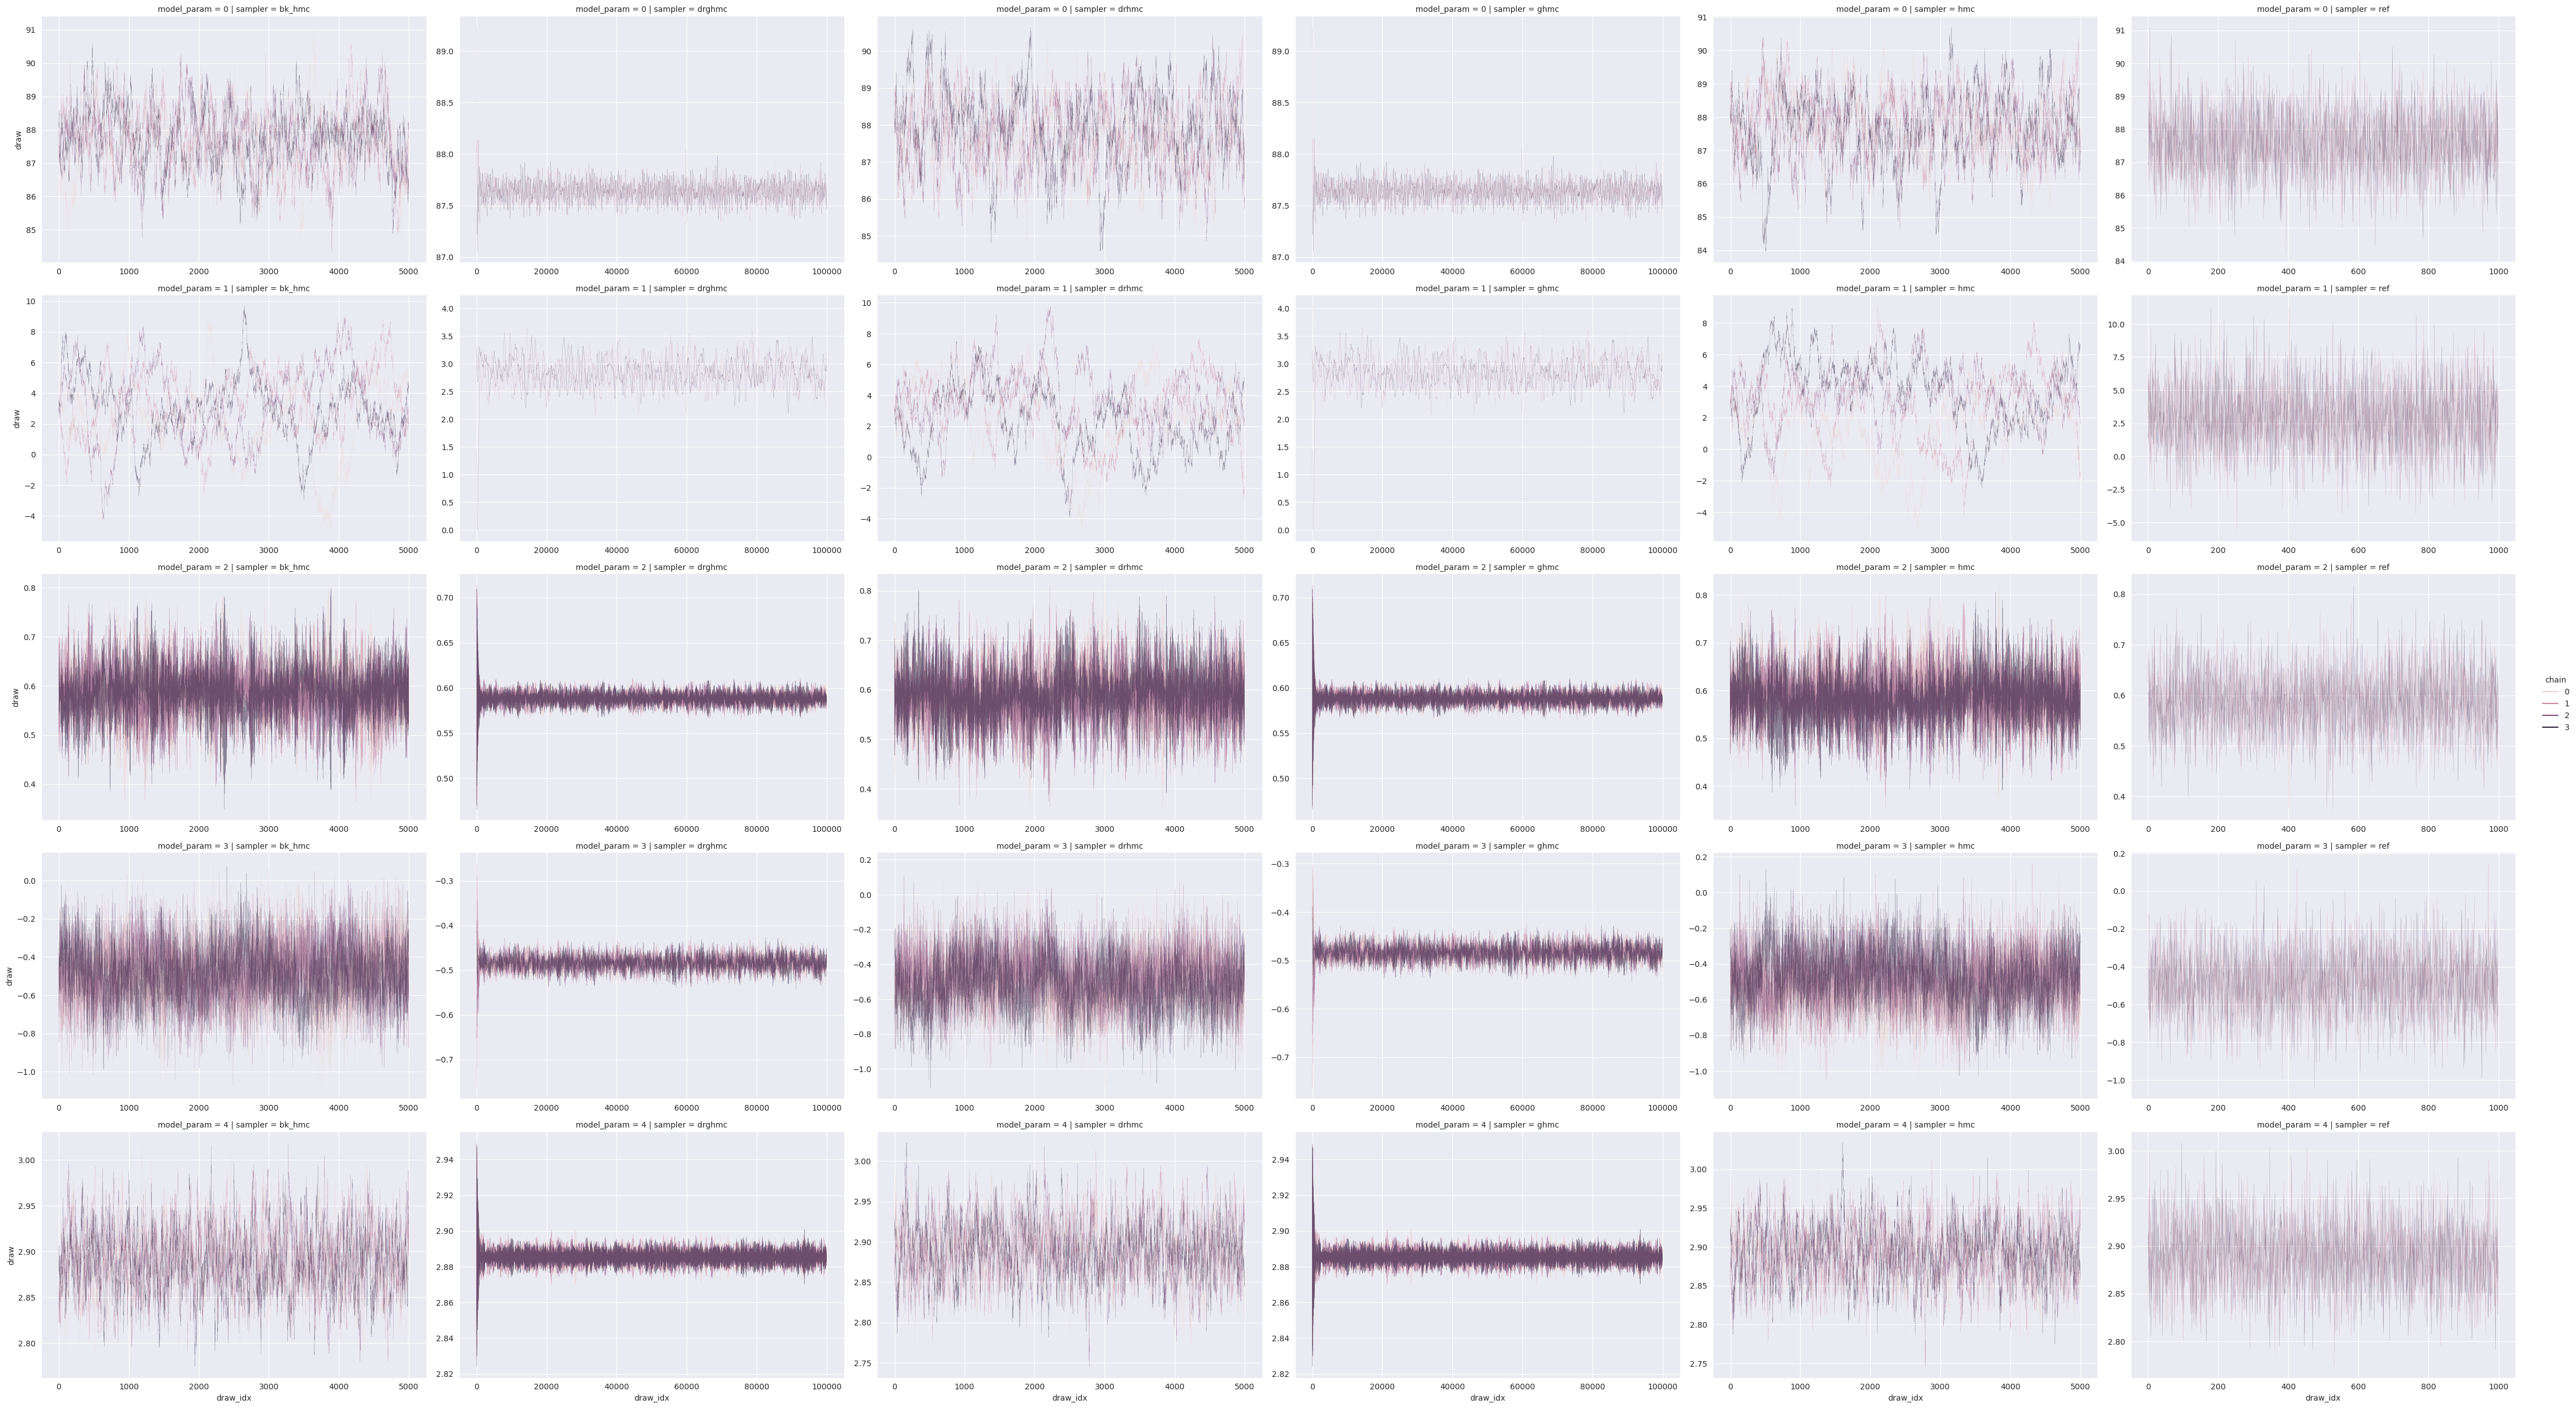

In [57]:
sns.relplot(data=draws_df, x="draw_idx", y="draw", 
            row="model_param", col="sampler",
            kind="line", hue="chain",
            aspect=1.5, linewidth=0.2, alpha=0.5,
            facet_kws={"sharey": False, "sharex": False},
)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


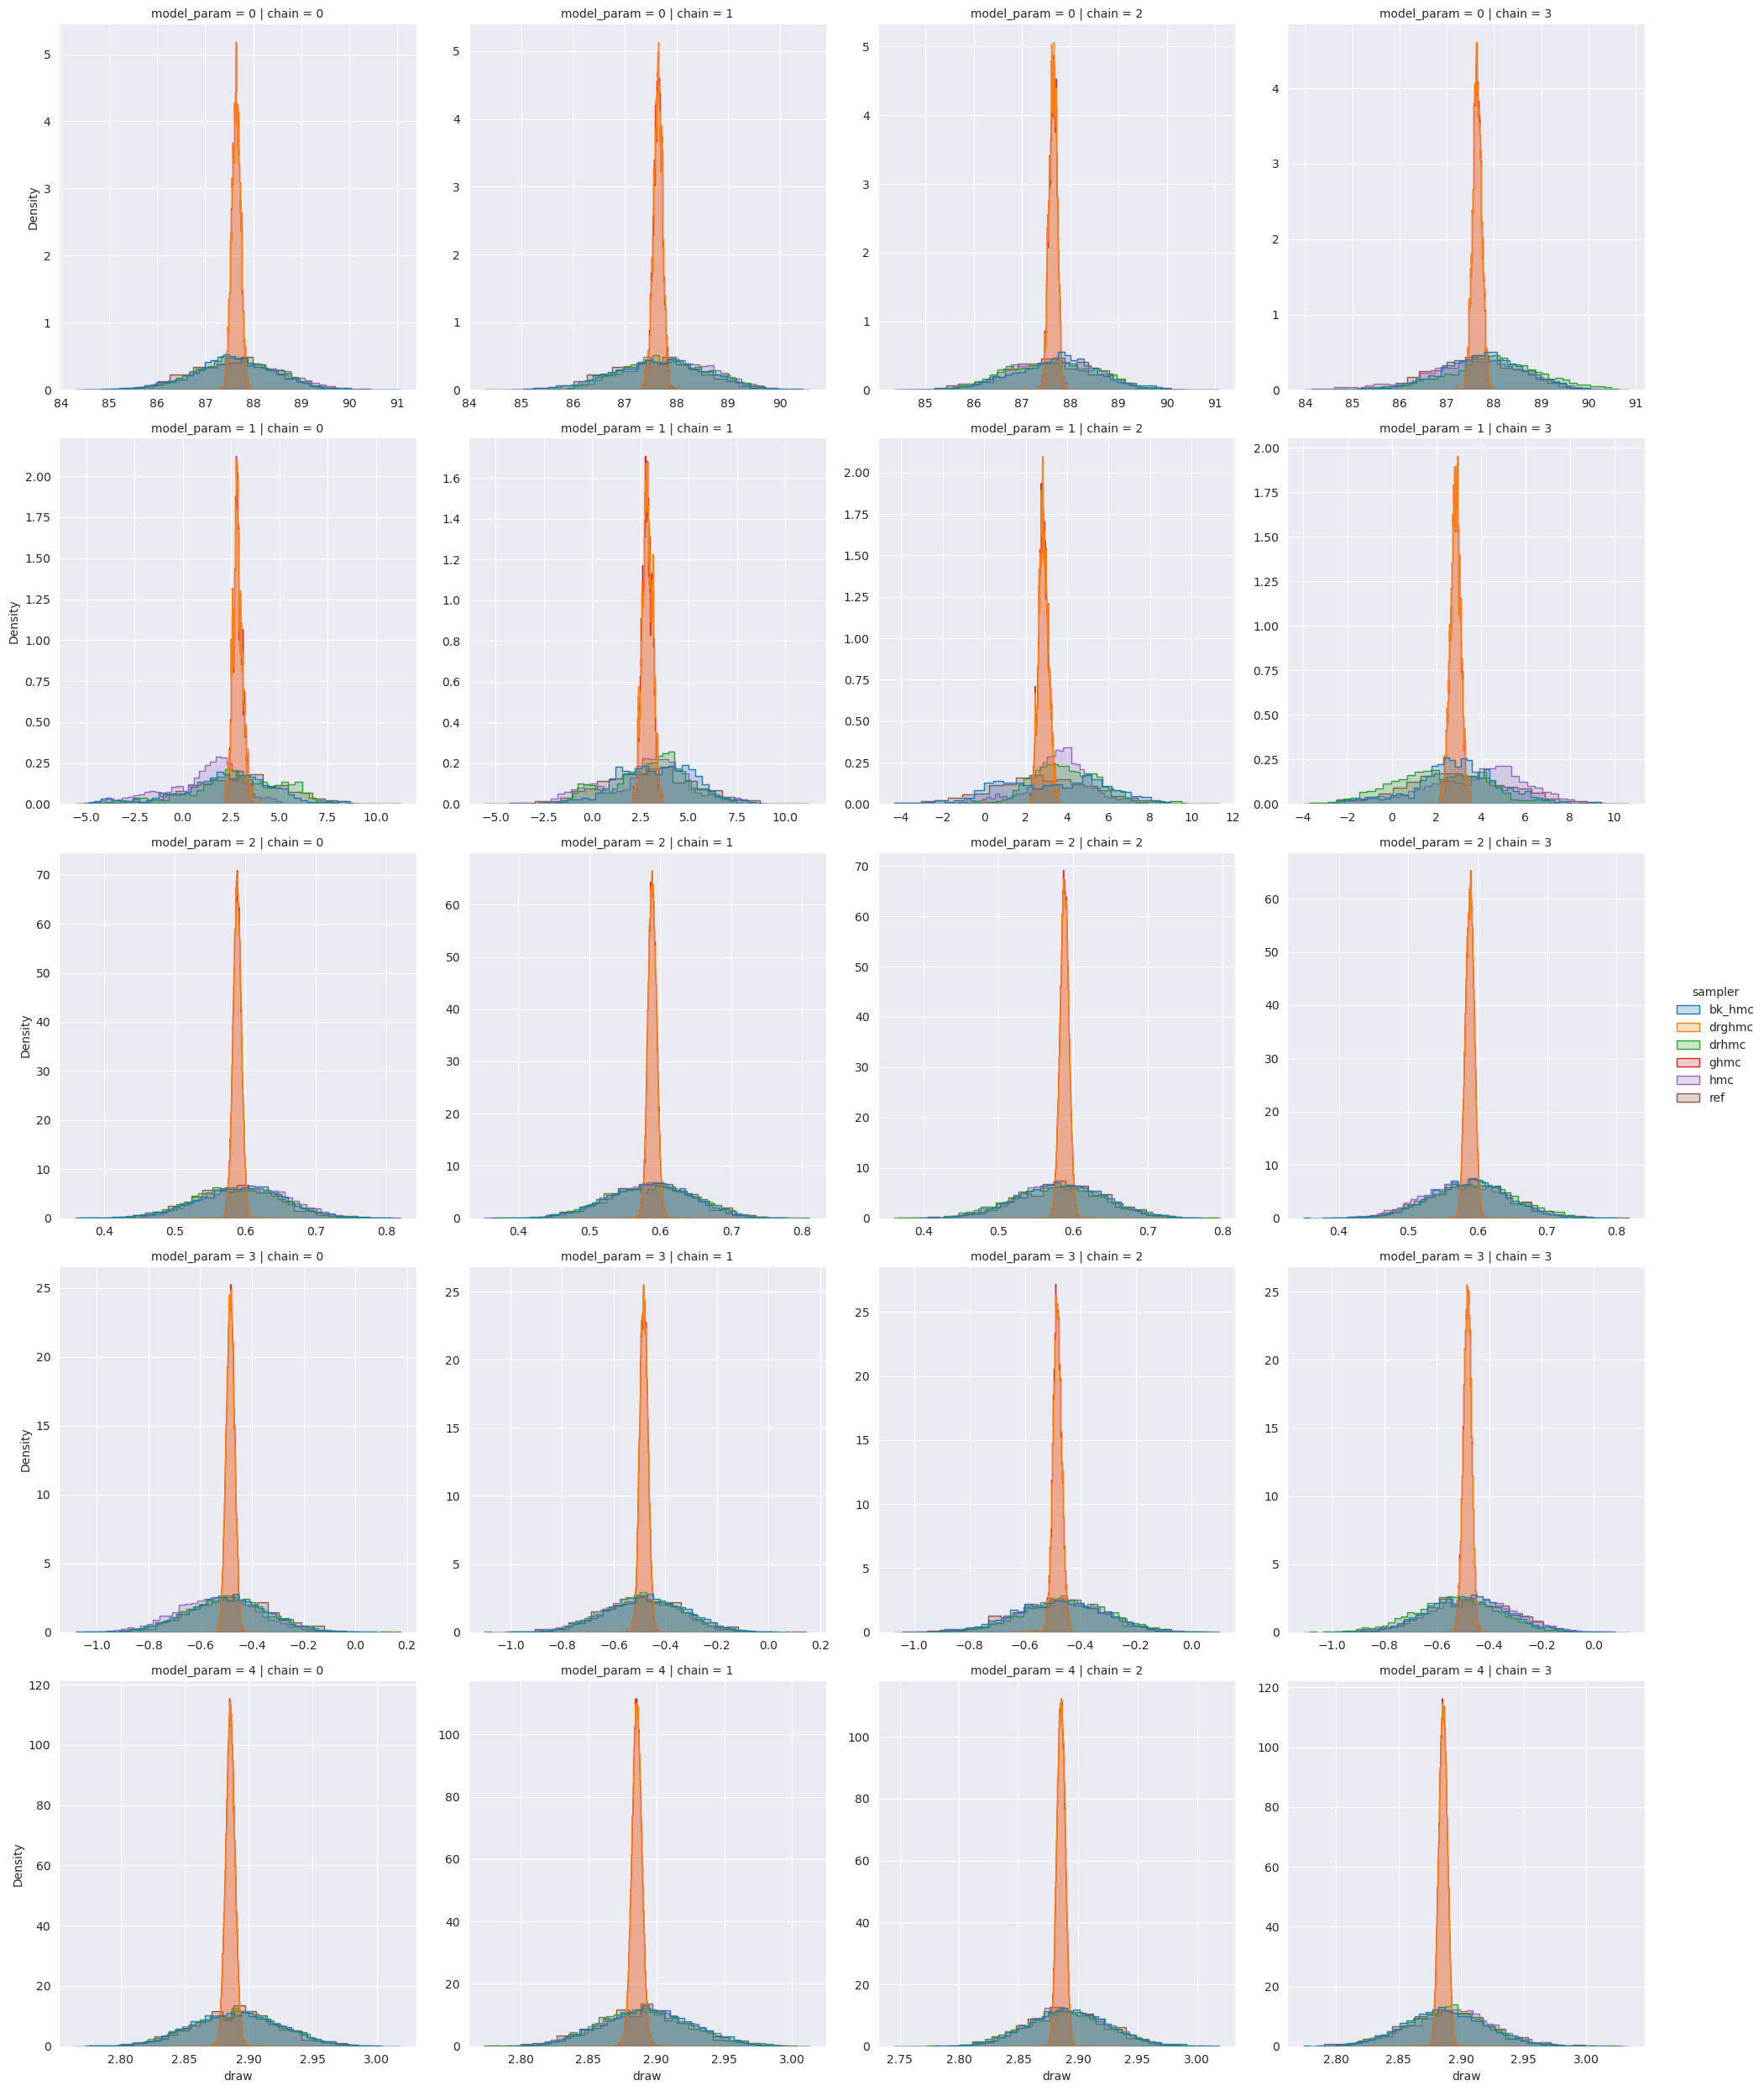

In [44]:
sns.displot(data=draws_df, x="draw", hue="sampler",
            row="model_param", col="chain", 
            common_norm=False, stat="density",
            element="step", common_bins=False,
            facet_kws={"sharex": False, "sharey": False},
)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


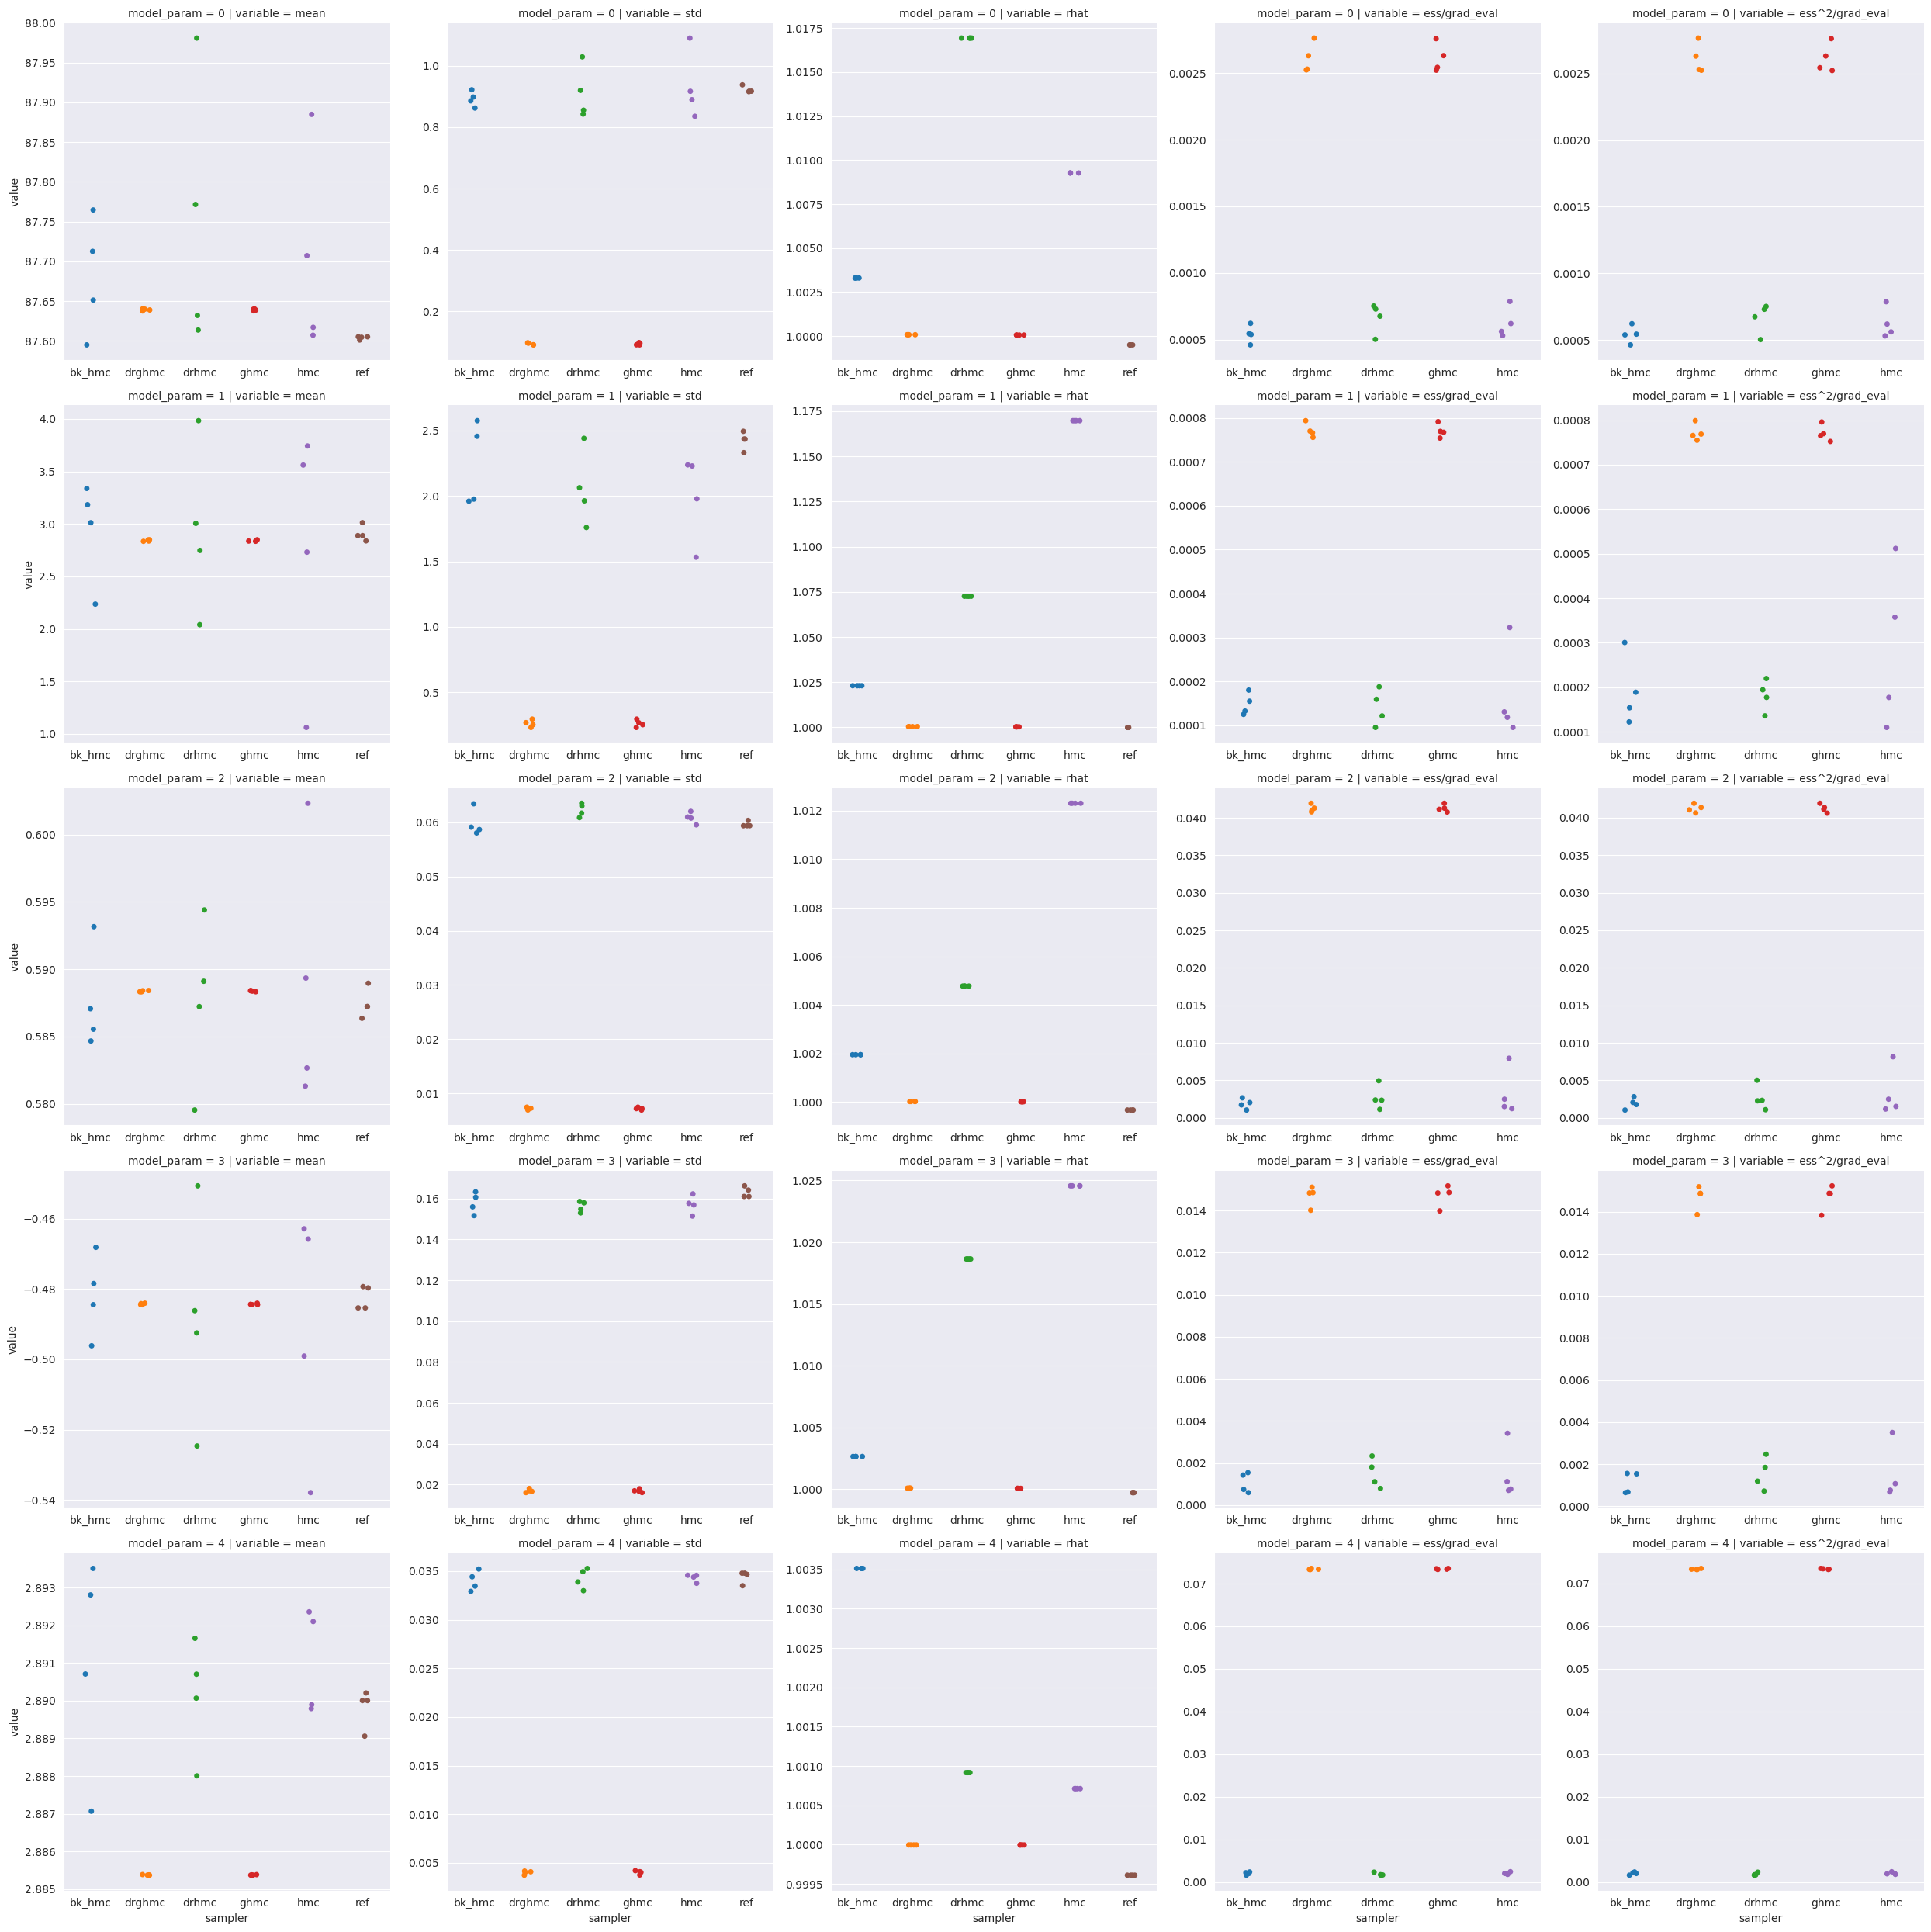

In [46]:
# sns.catplot(data=stats_df, x="sampler", y="ess/grad_eval", col="model_param", hue="sampler", sharey=False, sharex=False)

melted = pd.melt(stats_df, id_vars=["model_param", "sampler", "chain"], value_vars=["mean", "std", "rhat", "ess/grad_eval", "ess^2/grad_eval"])
sns.catplot(data=melted, x="sampler", y="value", row="model_param", col="variable", hue="sampler", sharex=False, sharey=False)